In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torchvision

In [4]:
from torchvision import datasets, transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from matplotlib import patches

In [ ]:
# !pip install pascal-voc-tools

In [5]:
!pip install fiftyone

     |████████████████████████████████| 1.1 MB 12.4 MB/s 
     |████████████████████████████████| 131 kB 50.8 MB/s 
     |████████████████████████████████| 79.9 MB 47 kB/s 
     |████████████████████████████████| 106 kB 53.3 MB/s 
     |████████████████████████████████| 13.2 MB 149 kB/s 
     |████████████████████████████████| 36.7 MB 51 kB/s 
     |████████████████████████████████| 631 kB 42.6 MB/s 
     |████████████████████████████████| 224 kB 45.7 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 557 kB 27.6 MB/s 
     |████████████████████████████████| 29.2 MB 24 kB/s 
     |████████████████████████████████| 77 kB 5.9 MB/s 
     |████████████████████████████████| 58 kB 3.2 MB/s 
     |████████████████████████████████| 77 kB 6.8 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 7.8 MB 40.8 MB/s 
     |███████████████████████

In [6]:
import fiftyone as fo
import fiftyone.zoo as foz

In [7]:
! pip install kaggle

In [8]:
! mkdir ~/.kaggle

In [9]:
! cp /content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/kaggle.json ~/.kaggle/


In [10]:
! chmod 600 ~/.kaggle/kaggle.json


In [11]:
! kaggle datasets download andywl/rsna-512

100% 5.36G/5.37G [02:01<00:00, 28.0MB/s]
100% 5.37G/5.37G [02:01<00:00, 47.6MB/s]


In [12]:
! unzip /content/rsna-512.zip

Streaming output truncated to the last 5000 lines.
  inflating: d5252a78-3ea1-48e9-9ffb-e7535be3ce80.png  
  inflating: d525eafb-8908-45fd-a942-48d07c435487.png  
  inflating: d5265640-17db-4880-866d-d2952e32941c.png  
  inflating: d5277276-f8f8-40e9-b8e1-791cf5d96ac0.png  
  inflating: d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.png  
  inflating: d5293a3e-f050-4b98-8bbf-1f40e25bced5.png  
  inflating: d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.png  
  inflating: d52ce67b-be7c-4349-8dc4-38562928d208.png  
  inflating: d535a3c8-c4a4-4856-b5cd-17f6332eac8b.png  
  inflating: d5360dc4-6bea-4a7b-bc49-5b2547ad7877.png  
  inflating: d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.png  
  inflating: d539e101-5662-445c-9f6a-381e674f0aed.png  
  inflating: d53cee27-787e-4136-aaf6-03bcff985ac9.png  
  inflating: d53ebae4-9b96-4a05-b066-4635d52e3ac2.png  
  inflating: d54150ef-1739-4002-aaef-e4e8441038b1.png  
  inflating: d54240c5-1375-42c8-85b5-e77968f6befc.png  
  inflating: d5431b84-9bf2-4758-badc-569e71ee1f9a.png

In [ ]:
# ! kaggle datasets download andywl/rsna-512-gt-json


In [13]:
# The directory containing the source images
#data_path = "/content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/Fold1/valid"
data_path = '/content/RSNA_512/RSNA_train_512'
# The path to the COCO labels JSON file
#labels_path =  "/content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/Fold1/fold1_valid.json"
labels_path = '/content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/RSNA_512_gt.json'
# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path,
)

 100% |█████████████| 26684/26684 [36.0s elapsed, 0s remaining, 714.3 samples/s]      


In [ ]:
print(dataset)

Name:        2021.08.23.17.26.12
Media type:  image
Num samples: 26684
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [ ]:
session = fo.launch_app(dataset)

Output hidden; open in https://colab.research.google.com to view.

Sanity check to make sure the dataset loaded correctly (comparing it with the direct gt from the csv file)

In [ ]:

###function to view gt bboxes
def view_gt_image(gt_path, img_path):
  '''
  function takes in a path to gt csv, an path to image
  '''
  gt = pd.read_csv(gt_path)
  #img, target = dataset_test.__getitem__(idx)
  #print(target)
  #img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
  #img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
  #img = np.array(img)  # tensor → ndarray
  img = Image.open(img_path)
  imgname = img_path.split("/")[-1]
  imgname = imgname.split(".")[0]
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  plt.imshow(img, cmap='gray')
  targets = {"boxes":[]}
  for _,row in gt[gt.id == imgname].iterrows():
  
    if row["class"] == "opacity":
      xmin = row.xmin
      ymin = row.ymin
      xmax = row.xmax
      ymax = row.ymax
      targets["boxes"].append([xmin,ymin,xmax,ymax])
         
      width = xmax - xmin
      height = ymax - ymin
      # cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), thickness=8)
      # cv2.putText(img, 'opacity', (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0),
      #                    thickness=2)
      edgecolor = 'r'
      ax.annotate('opacity' , xy=(xmax-40,ymin+20), color = 'g')
          
      # add bounding boxes to the image
      rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
      
      ax.add_patch(rect)
  return targets

In [ ]:
pth = '/content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/Fold1/valid/3b982073ec16_image.png'
df_path = '/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/df_ground_truth.csv'

{'boxes': [[63, 3, 113, 121], [367, 21, 438, 97]]}

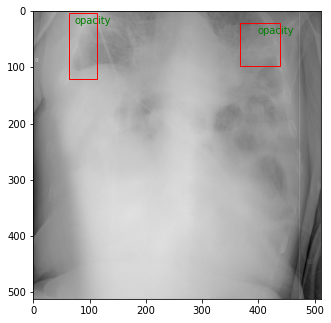

In [ ]:
view_gt_image(df_path, pth)


**Evaluate**

In [ ]:
# from numba import cuda
# # import torch
# cuda.select_device(0)
# cuda.close()
# cuda.select_device(0)

reset context of device 0


<weakproxy at 0x7f9edbac2590 to Device at 0x7f9edac37790>

In [14]:
###Load Faster RCNN model
num_classes=2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True) #torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)
weights_path = '/content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/Best FRCNN/fold5_FRCNN_Resnet14_5202.pt' #'/content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/Best FRCNN/fold4_FRCNN_Resnet14_484.pt' #'/content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/Best FRCNN/fold3_FRCNN_Resnet29_5354.pt' #'/content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/Best FRCNN/fold1_FRCNN_Resnet24_4989.pt' #'/content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/Faster_RCNN_batch4_lr0.001_fold2/Faster_RCNN_resnet14.pt' #'/content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/Positives_only/fold1_positive_best_retinanet_resnet29.pt' #r'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/Faster_RCNN/Faster RCNN models/faster_rcnn_resnet27.pt'#'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/Faster_RCNN/Faster_RCNN_ResNet50_5.pkl'
checkpoint = torch.load(weights_path)#, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
#model =  torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)  # Or get_object_detection_model(num_classes)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [21]:
# from numba import cuda
# # import torch
# cuda.select_device(0)
# cuda.close()
# cuda.select_device(0)

init
reset context of device 0


<weakproxy at 0x7f2373098c50 to Device at 0x7f24589d8710>

In [22]:
###FOR CHEXNET
num_classes=2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net =  torchvision.models.densenet121(pretrained=False)


#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True) #torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)



In [23]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torch.backends.cudnn as cudnn
import torch.nn as nn
# load a pre-trained model for classification and return
# only the features
backbone = net.features
# CKPT_PATH = '/content/CheXNet/model.pth.tar'
# N_CLASSES = 14
# cudnn.benchmark = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#checkpoint = torch.load(CKPT_PATH)
#model = torch.load(os.path.join(patch_classifier_model_dir, "densenet121.pt"))


#torchision.modeks.DenseNet121(N_CLASSES)#DenseNet121(N_CLASSES).cuda()
# checkpoint = torch.load(CKPT_PATH)
# net.load_state_dict(checkpoint['state_dict'],strict=False)
# backbone = net.features
#net.densenet121.classifier = nn.Sequential(*list(net.densenet121.classifier.children())[:-3])

#backbone = MyEfficientNet.from_pretrained(model_name='efficientnet-b0', num_classes=2)
#backbone.out_channels = 1280  # EfficientNet-B0
#backbone = backbone.features
#backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1024

In [24]:

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
# anchor_generator = AnchorGenerator(sizes=((90, 156, 133, 74, 126,8,200),),
#                                    aspect_ratios=((0.49235746, 0.47750278, 0.9577508, 0.81768437, 0.51451598, 0.6, 0.1, 1.5),))

# anchor_generator = AnchorGenerator(sizes=((224, 416, 512),),
#                                     aspect_ratios=(( 0.5 ,1/0.9577508, 1/0.81768437, 1/0.51451598,  1/0.2, 1/1.5),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2, canonical_scale = 512)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2, #including background class 0 
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
#grcnn = torchvision.models.detection.transform.GeneralizedRCNNTransform(min_size=800, max_size=1333, image_mean=[0.485], image_std=[0.229])
#model.transform = grcnn
model.to(device)

RuntimeError: ignored

In [ ]:
weights_path = '/content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/Chexnet_with_finetuning/ft_fold2/faster_rcnn_ChexNet2.pt' #'/content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/Chexnet_with_finetuning/fold2/faster_rcnn_ChexNet18.pt'#'/content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/fold2_FRCNN_Chexnet_SAME_ANCHORS_b4_lr0.001/faster_rcnn_ChexNet35.pt'#'/content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/Faster_RCNN_batch4_lr0.001_fold2/Faster_RCNN_resnet14.pt' #'/content/drive/Shareddrives/COVID-19_X-Ray/Detection_Training/Positives_only/fold1_positive_best_retinanet_resnet29.pt' #r'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/Faster_RCNN/Faster RCNN models/faster_rcnn_resnet27.pt'#'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/Faster_RCNN/Faster_RCNN_ResNet50_5.pkl'
checkpoint = torch.load(weights_path)#, map_location='cpu')
modelCheckpoint = checkpoint['model_state_dict']
model.load_state_dict(modelCheckpoint)

<All keys matched successfully>

**End of ChexNet**

In [ ]:
dataset

Name:        2021.08.22.04.46.54
Media type:  image
Num samples: 26684
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

In [15]:
predictions_view = dataset.take(dataset.count())
print(predictions_view)

Dataset:     2021.08.24.23.43.33
Media type:  image
Num samples: 26684
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. Take(size=26684, seed=None)


In [ ]:
!git clone https://github.com/ZFTurbo/Weighted-Boxes-Fusion.git

Cloning into 'Weighted-Boxes-Fusion'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 136 (delta 68), reused 100 (delta 39), pack-reused 0
Receiving objects: 100% (136/136), 37.78 KiB | 12.59 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [ ]:
os.chdir('/content/Weighted-Boxes-Fusion')

In [ ]:
from ensemble_boxes import *

In [ ]:
# bf, sf, lf = weighted_boxes_fusion([[[0,0, 1, 1],[0,0,1,2]]], [[0.9, 0.3]], [[1,1]])

/content/Weighted-Boxes-Fusion/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning:

Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.



In [16]:
from torchvision.transforms import functional as func
# Get class list
classes = ['none','opacity']#dataset.info["classes"]

# Add predictions to samples
with fo.ProgressBar() as pb:
    for sample in pb(predictions_view):
        # Load image
        image = Image.open(sample.filepath)
        image = func.to_tensor(image).to(device)
        c, h, w = image.shape
        model.eval()
        # Perform inference
        preds = model([image])[0]
        
        labels = preds["labels"].cpu().detach().numpy()
        scores = preds["scores"].cpu().detach().numpy()
        boxes = preds["boxes"].cpu().detach().numpy()

        # l = []
        # s = []
        # b = []

        # l.append(labels.tolist())
        # s.append(scores.tolist())
        # b.append(boxes.tolist())
        
        # boxes, scores, labels = weighted_boxes_fusion(b,s,l)
        
        # Convert detections to FiftyOne format
        detections = []
        for label, score, box in zip(labels, scores, boxes):
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]
           
            detections.append(fo.Detection(
                label=classes[int(label)],
                bounding_box=rel_box,
                confidence=score
            ))
        
        # Save predictions to dataset svae indeed done yooo fam ronaldo
        sample["Chexnet FRCNN WBF"] = fo.Detections(detections=detections)
        sample.save()

print("Finished adding predictions")

   0% ||------------|     0/26684 [140.3ms elapsed, ? remaining, ? samples/s] 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 100% |█████████████| 26684/26684 [2.0h elapsed, 0s remaining, 3.7 samples/s]      
Finished adding predictions


In [ ]:
predictions_view #bukayo huj mawla lolo  yees here still here yes i am joao pessoas yeesh I am here man here herw im here Iamhere

Dataset:     2021.08.21.23.08.50
Media type:  image
Num samples: 26684
Tags:        []
Sample fields:
    id:                fiftyone.core.fields.ObjectIdField
    filepath:          fiftyone.core.fields.StringField
    tags:              fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    Chexnet FRCNN WBF: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. Take(size=26684, seed=None)

In [ ]:
session = fo.launch_app(dataset)

In [17]:
import fiftyone.utils.eval as foue

result = foue.evaluate_detections(predictions_view, "Chexnet FRCNN WBF", gt_field="ground_truth", compute_mAP=True, iou_threshs= [0.5])

Evaluating detections...
 100% |█████████████| 26684/26684 [6.0m elapsed, 0s remaining, 87.9 samples/s]       
Performing IoU sweep...
 100% |█████████████| 26684/26684 [6.1m elapsed, 0s remaining, 89.6 samples/s]       


In [20]:
print(result.mAP())

0.2312505524500595


In [19]:
plot = result.plot_pr_curves(classes=["opacity"])
plot.show()

In [20]:
session = fo.launch_app(dataset)

In [ ]:
print(predictions_view)

Dataset:     2021.08.06.16.35.28
Media type:  image
Num samples: 1267
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    faster_rcnn:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. Take(size=1267, seed=None)
